<a href="https://colab.research.google.com/github/artsasse/fedkan/blob/main/Flower_MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a Federated MLP to classify MNIST

This notebook is based mainly on the Flower Tutorial "Use a federated learning strategy", found in https://flower.ai/docs/framework/tutorial-series-use-a-federated-learning-strategy-pytorch.html .

## Global Values

In [111]:
NUM_PARTITIONS = 100
BATCH_SIZE = 100
LOCAL_EPOCHS = 1
FRACTION_CLIENTS = 0.1
COMM_ROUNDS = 10
NET_TYPE = "fastkan"
LEARNING_RATE = 0.1
MOMENTUM = 0.9
HISTORY = {}
TRY_DEVICE = "cpu"
SEED = 13

## Dependencies

In [90]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

In [91]:
# Efficient KAN
!pip install -q git+https://github.com/Blealtan/efficient-kan.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [92]:
!pip install -q git+https://github.com/ZiyaoLi/fast-kan.git

  Preparing metadata (setup.py) ... done


In [93]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import random
import os
import re
import json
from logging import INFO

from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents, SimpleClientManager
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation, start_simulation
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import PathologicalPartitioner
from flwr_datasets.visualization import plot_label_distributions
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context, Metrics
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion

from efficient_kan import KAN
from fastkan import FastKAN

DEVICE = torch.device(TRY_DEVICE)  # "cpu" or "cuda" ("mps" for Apple Silicon)
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cpu
Flower 1.11.1 / PyTorch 2.4.1+cu121


## Configuring Seeds

In [94]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

## Data loading

In [95]:
def create_flower_dataset():

    # Like FedProx partition, but clients have similar number of examples
    partitioner = PathologicalPartitioner(
        num_partitions=NUM_PARTITIONS,
        partition_by="label",
        num_classes_per_partition=2,
        shuffle=True,
        seed=SEED
        )

    fds = FederatedDataset(
        dataset="mnist",
        partitioners={"train": partitioner},
        shuffle=True,
        seed=SEED
        )

    return fds

In [96]:
def load_datasets(partition_id: int, num_partitions: int):

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,)),
         transforms.Lambda(lambda x: torch.flatten(x))  # Flatten the image into a 1D tensor
         ]
    )

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    fds = create_flower_dataset()

    partition = fds.load_partition(partition_id).with_transform(apply_transforms)
    trainloader = DataLoader(partition, batch_size=BATCH_SIZE, shuffle=True,
                            #  worker_init_fn=seed_worker, generator=g
                             )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                            # worker_init_fn=seed_worker, generator=g
                            )

    return trainloader, testloader

### Partition Visualization

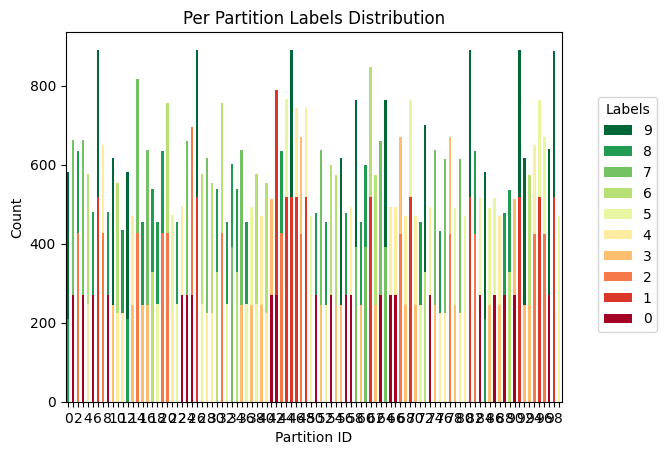

In [97]:
visual_fds = create_flower_dataset()
visual_partitioner = visual_fds.partitioners["train"]
fig, ax, df = plot_label_distributions(
    visual_partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)

In [98]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
Partition ID,,,,,,,,,,
0,0,0,0,0,0,0,0,0,209,372
1,270,0,0,0,0,0,0,392,0,0
2,0,0,426,0,0,0,0,0,209,0
3,270,0,0,0,0,0,0,392,0,0
4,0,0,0,0,0,247,329,0,0,0
...,...,...,...,...,...,...,...,...,...,...
95,0,518,0,0,0,246,0,0,0,0
96,0,0,425,0,0,246,0,0,0,0
97,269,0,0,0,0,0,0,0,0,371


## Model training/evaluation (PyTorch)

In [108]:
class MLPNet(nn.Module):

    def __init__(self) -> None:
        super(MLPNet, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 200)  # 28 x 28 pixels
        self.layer2 = nn.Linear(200, 200)  # 2 hidden layers with 200 neurons each
        self.layer3 = nn.Linear(200, 10)  # 10 classes
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x

class KANNet(KAN):
    def __init__(self) -> None:
        super().__init__([28 * 28, 24, 24, 10])

class FastKANNet(FastKAN):
    def __init__(self) -> None:
        super().__init__([28 * 28, 24, 24, 10])

def create_network(net_type: str = NET_TYPE):
    if net_type == "mlp":
        return MLPNet()
    elif net_type == "kan":
        return KANNet()
    elif net_type == "fastkan":
        return FastKANNet()
    else:
        raise ValueError(f"Unknown network type: {net_type}")

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        net.parameters(),
        lr=LEARNING_RATE,
        momentum=MOMENTUM)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        return epoch_loss, epoch_acc


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Flower Architecture

### Flower client

In [100]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader=None):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epoch_loss, epoch_accuracy = train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {"epoch_loss": float(epoch_loss),
                                                                 "epoch_accuracy": float(epoch_accuracy)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = create_network().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, _ = load_datasets(partition_id, num_partitions)
    return FlowerClient(partition_id, net, trainloader).to_client()

### Server-side parameter **evaluation**

#### Save evaluation results

In [101]:
def create_new_history():
    history = {"net_type": NET_TYPE,
              "test_accuracy": [],
              "test_loss": [],
              "train_accuracy": [0.0], # No fit metrics before the first round
              "train_loss": [0.0],
              "execution_time": 0,
              "seed": SEED,
              "batch_size": BATCH_SIZE,
              "local_epochs": LOCAL_EPOCHS,
              "fraction_clients": FRACTION_CLIENTS,
              "comm_rounds": COMM_ROUNDS,
              "num_partitions": NUM_PARTITIONS,
              "device": str(DEVICE),
              "learning_rate": LEARNING_RATE,
              "momentum": MOMENTUM,
              }
    return history

# Need to use a global var because we can't pass our dictionary as argument
def save_test_metrics(server_round: int, accuracy: float, loss: float):
    HISTORY["test_accuracy"].append((accuracy, server_round))
    HISTORY["test_loss"].append((loss, server_round))

# Currently can't capture the server round inside the fit aggregation function
def save_train_metrics(accuracy: float, loss: float):
    HISTORY["train_accuracy"].append(accuracy)
    HISTORY["train_loss"].append(loss)

def save_execution_time(execution_time: float):
    HISTORY["execution_time"] = execution_time

#### Evaluation function

In [102]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = create_network().to(DEVICE)
    _, testloader = load_datasets(0, NUM_PARTITIONS)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    save_test_metrics(server_round, accuracy, loss)
    return loss, {"accuracy": accuracy}

### Training **Configuration** (e.g. epochs)




In [103]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": LOCAL_EPOCHS,
    }
    return config

### Flower **Server**

#### Fit (training) Metrics Aggregation

In [104]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Inspired by https://github.com/adap/flower/blob/0e7c1b06c32ab90e0d3cf64825ed51eedd715509/examples/custom-mods/server.py"""

    # Get number of examples for each client used for training
    examples = [num_examples for num_examples, _ in metrics]

    # Multiply accuracy of each client by number of examples used
    train_losses = [
        num_examples * float(m["epoch_loss"]) for num_examples, m in metrics
    ]
    train_accuracies = [
        num_examples * float(m["epoch_accuracy"]) for num_examples, m in metrics
    ]

    train_loss = sum(train_losses) / sum(examples)
    train_accuracy = sum(train_accuracies) / sum(examples)

    save_train_metrics(train_accuracy, train_loss)

    # Aggregate and return custom metric (weighted average)
    return {
        "train_loss": sum(train_losses) / sum(examples),
        "train_accuracy": sum(train_accuracies) / sum(examples),
    }

#### Server function

In [105]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=FRACTION_CLIENTS,
        fraction_evaluate=0,
        min_fit_clients=1,
        min_evaluate_clients=0,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
        on_fit_config_fn=fit_config,
        fit_metrics_aggregation_fn=weighted_average,
    )

    config = ServerConfig(num_rounds=COMM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

## Helpers

### Get simulation execution time from Flower logs

In [106]:
def get_elapsed_time(log_filepath) -> float:
    with open(log_filepath, 'r') as f:
        log_content = f.read()

        pattern = r'Run finished \d+ round\(s\) in (\d+\.\d+)s'
        regex_match = re.search(pattern, log_content)

        if regex_match:
            elapsed_time = float(regex_match.group(1))
            print(f"Simulation execution time: {elapsed_time} seconds")
            return elapsed_time
        else:
            print("Could not find elapsed time.")
            return None

## Simulation

### Global model **initialization**

In [112]:
# Create an instance of the model and get the parameters
initial_model = create_network()
params = get_parameters(initial_model)
total_params = sum(p.numel() for p in initial_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 170426


### Run Simulation

In [110]:
# Define hardware resources
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_gpus": 0.25, "num_cpus": 2}}
else:
    backend_config = {"num_cpus": 2}

# Create Apps
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

# create new history
HISTORY = create_new_history()

# Configure logs
log_id = f"log_{NET_TYPE}_seed_{SEED}"
log_filename = f"{log_id}.txt"
flwr.common.logger.configure(
    identifier=log_id,
    filename=log_filename)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

save_execution_time(get_elapsed_time(log_filename))

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
ERROR :     ServerApp thread raised an exception: The size of tensor a (784) must match the size of tensor b (8) at non-singleton dimension 1
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/run_simulation.py", line 336, in server_th_with_start_checks
    run_server_app(
  File "/usr/local/lib/python3.10/dist-packages/flwr/server/run_serverapp.py", line 88, in run
    server_app(driver=driver, context=context)
  File "/usr/local/lib/python3.10/dist-packages/flwr/server/server_app.py", line 120, in __call__
    start_driver(
  File "/usr/local/lib/python3.10/dist-packages/flwr/server/compat/app.py", line 87, in start_driver
    hist = run_fl(
  File "/usr/local/lib/python3.10/dist-packages/flw

RuntimeError: Exception in ServerApp thread

### Serialize Results and Save to Google Drive

In [23]:
drive.mount('/content/drive')
folder = "/content/drive/MyDrive/Colab Notebooks/KANs/Pilot Results/"
filename = f"hist_{NET_TYPE}_s{SEED}_r{COMM_ROUNDS}_{str(DEVICE)}.json"
filepath = folder + filename
print(f"Saving to {filepath}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving to /content/drive/MyDrive/Colab Notebooks/KANs/Pilot Results/hist_fastkan_s12_r10_cpu.json


In [24]:
with open(filepath, 'w') as f:
    json.dump(HISTORY, f, indent=4)

In [25]:
with open(filepath, 'r') as f:
    x = json.load(f)
x

{'net_type': 'fastkan',
 'test_accuracy': [[0.081, 0],
  [0.1003, 1],
  [0.1028, 2],
  [0.1008, 3],
  [0.1032, 4],
  [0.1009, 5],
  [0.0958, 6],
  [0.1135, 7],
  [0.1032, 8],
  [0.0958, 9],
  [0.0892, 10]],
 'test_loss': [[0.025990361952781676, 0],
  [0.027968997526168823, 1],
  [0.027414683985710144, 2],
  [0.03319074811935425, 3],
  [0.031460355067253115, 4],
  [0.03310835509300232, 5],
  [0.042140061855316165, 6],
  [0.032376491355895994, 7],
  [0.03704170699119568, 8],
  [0.03334843697547912, 9],
  [0.030043880009651185, 10]],
 'train_accuracy': [0.0,
  0.4485798917248273,
  0.503462467434711,
  0.4927672846069353,
  0.5180940066464982,
  0.4683304303855114,
  0.4487091716022867,
  0.4586845332056681,
  0.5114880761168497,
  0.5256258226003179,
  0.4713760465157113],
 'train_loss': [0.0,
  0.02606146777237671,
  0.01301291625279544,
  0.01213874792536864,
  0.012453028015002157,
  0.014214705407732365,
  0.01457087455492001,
  0.023028706581416456,
  0.01336624295799993,
  0.013872

## Plot all results

### Gather JSON data from Google Drive

In [27]:
# Get a list of all JSON files in the folder
json_files = [f for f in os.listdir(folder) if f.endswith('.json')]

# Initialize separate lists for 'kan' and 'mlp' data
kan_data = []
mlp_data = []
fastkan_data = []

# Load and separate the data based on 'net_type'
for json_file in json_files:
    with open(os.path.join(folder, json_file), 'r') as f:
        data = json.load(f)
        if data['net_type'] == 'kan':
            kan_data.append(data)
        elif data['net_type'] == 'mlp':
            mlp_data.append(data)
        elif data['net_type'] == 'fastkan':
            fastkan_data.append(data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Extract metrics and hyperparameters from each execution

In [29]:
def aggregate_data(data_list):
    """ Aggregate metrics for a given list of JSON data """
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    execution_times = []

    for data in data_list:
        train_accuracies.append([acc for acc in data['train_accuracy'][1:]])  # Skip the first element
        test_accuracies.append([acc[0] for acc in data['test_accuracy'][1:]])  # Skip the first element
        train_losses.append([loss for loss in data['train_loss'][1:]])  # Skip the first element
        test_losses.append([loss[0] for loss in data['test_loss'][1:]])  # Skip the first element
        execution_times.append(data['execution_time'])

    # Convert lists to numpy arrays for easier aggregation
    train_accuracies = np.array(train_accuracies)
    test_accuracies = np.array(test_accuracies)
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    execution_times = np.array(execution_times)

    # Calculate means and standard deviations
    train_acc_mean = np.mean(train_accuracies, axis=0)
    train_acc_std = np.std(train_accuracies, axis=0)

    test_acc_mean = np.mean(test_accuracies, axis=0)
    test_acc_std = np.std(test_accuracies, axis=0)

    train_loss_mean = np.mean(train_losses, axis=0)
    train_loss_std = np.std(train_losses, axis=0)

    test_loss_mean = np.mean(test_losses, axis=0)
    test_loss_std = np.std(test_losses, axis=0)

    execution_time_mean = np.mean(execution_times)
    execution_time_std = np.std(execution_times)

    return train_acc_mean, train_acc_std, test_acc_mean, test_acc_std, train_loss_mean, train_loss_std, test_loss_mean, test_loss_std, execution_time_mean, execution_time_std

# Aggregate data for 'kan's and 'mlp'
kan_results = aggregate_data(kan_data)
mlp_results = aggregate_data(mlp_data)
fastkan_results = aggregate_data(fastkan_data)

# Assuming all gathered simulation had the same hyperparameters
hyperparameters = (f"lr={kan_data[0]['learning_rate']}, bs={kan_data[0]['batch_size']}, "
                  f"epochs={kan_data[0]['local_epochs']}, frac={kan_data[0]['fraction_clients']}")

# Define the communication rounds (assuming all files have the same number of rounds)
comm_rounds = list(range(1, len(kan_results[0]) + 1))

### Plot all Metrics

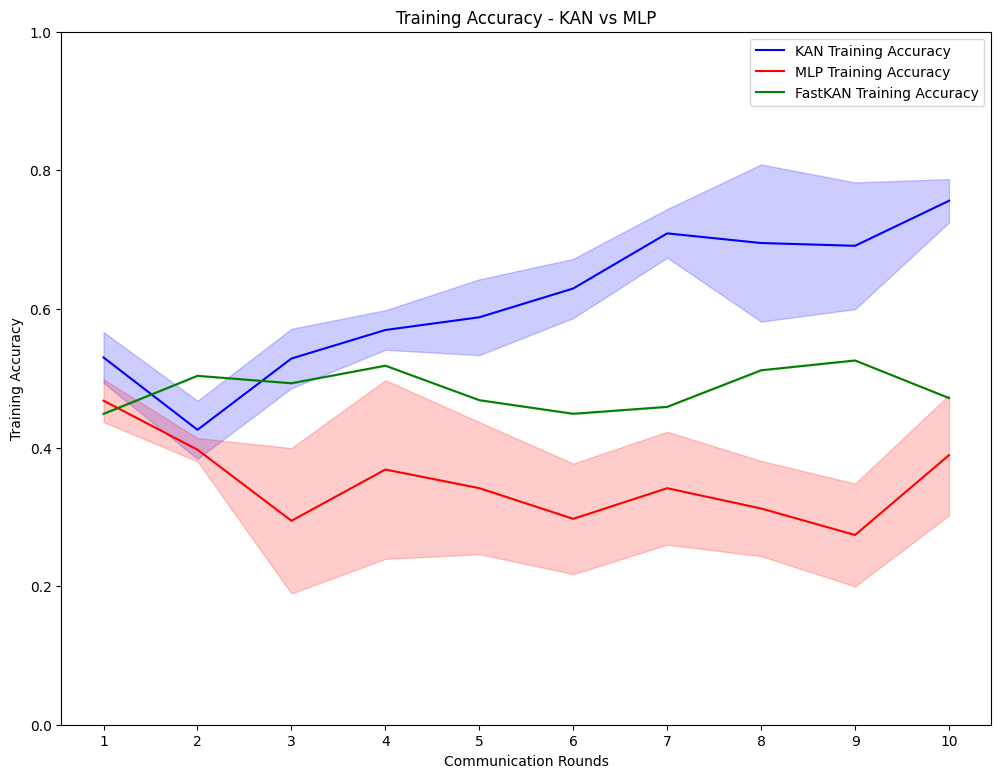

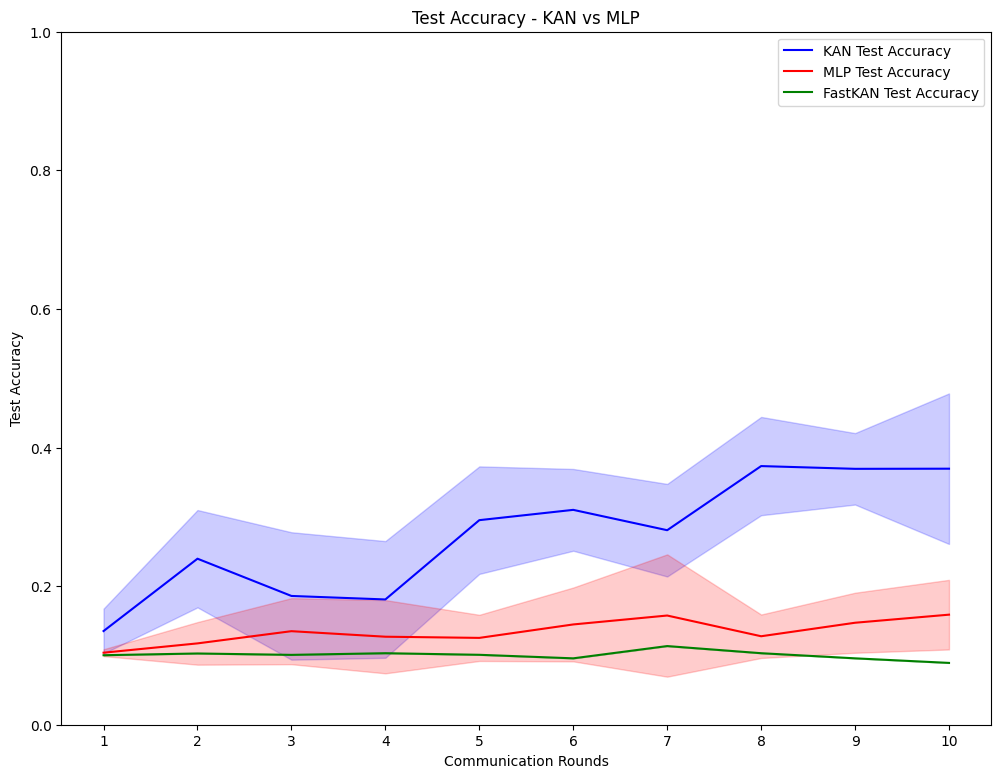

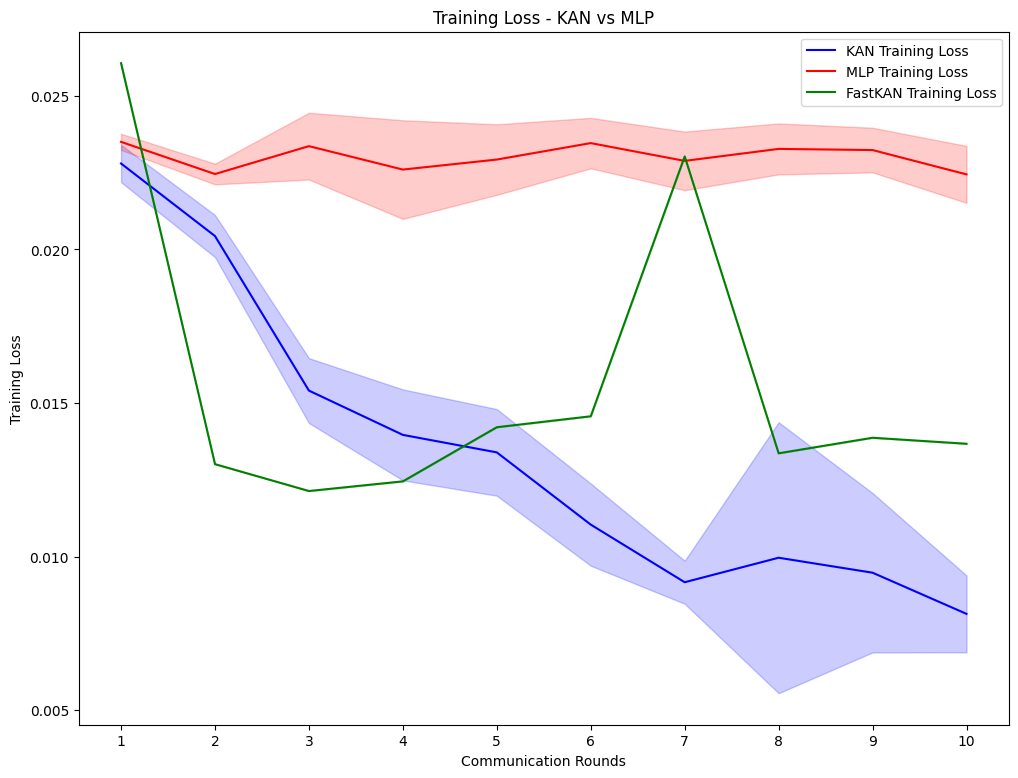

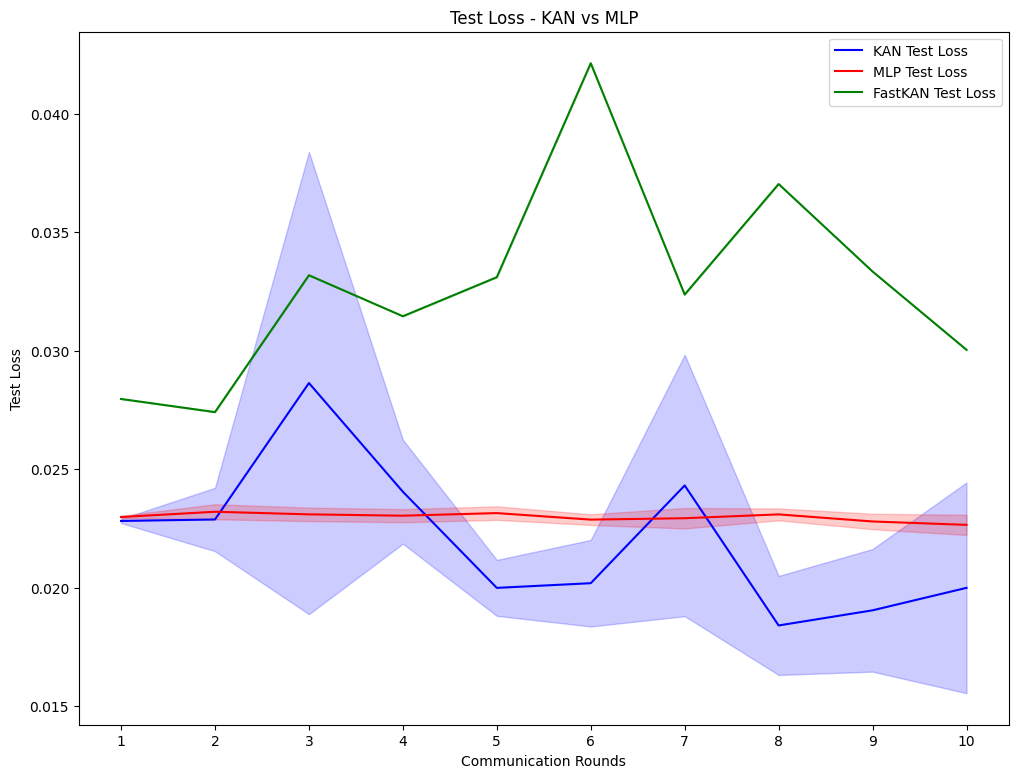

In [33]:
figsize=(12, 9)

# Plot Training Accuracy with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[0], 'b-', label='KAN Training Accuracy')
plt.fill_between(comm_rounds, kan_results[0] - kan_results[1], kan_results[0] + kan_results[1], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[0], 'r-', label='MLP Training Accuracy')
plt.fill_between(comm_rounds, mlp_results[0] - mlp_results[1], mlp_results[0] + mlp_results[1], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[0], 'g-', label='FastKAN Training Accuracy')
plt.fill_between(comm_rounds, fastkan_results[0] - fastkan_results[1], fastkan_results[0] + fastkan_results[1], color='g', alpha=0.2)

plt.title(f"Training Accuracy - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Training Accuracy")
plt.ylim(0, 1)
plt.xticks(comm_rounds)
plt.legend()
plt.show()

# Plot Test Accuracy with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[2], 'b-', label='KAN Test Accuracy')
plt.fill_between(comm_rounds, kan_results[2] - kan_results[3], kan_results[2] + kan_results[3], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[2], 'r-', label='MLP Test Accuracy')
plt.fill_between(comm_rounds, mlp_results[2] - mlp_results[3], mlp_results[2] + mlp_results[3], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[2], 'g-', label='FastKAN Test Accuracy')
plt.fill_between(comm_rounds, fastkan_results[2] - fastkan_results[3], fastkan_results[2] + fastkan_results[3], color='g', alpha=0.2)

plt.title(f"Test Accuracy - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Test Accuracy")
plt.ylim(0, 1)
plt.xticks(comm_rounds)
plt.legend()
plt.show()

# Plot Training Loss with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[4], 'b-', label='KAN Training Loss')
plt.fill_between(comm_rounds, kan_results[4] - kan_results[5], kan_results[4] + kan_results[5], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[4], 'r-', label='MLP Training Loss')
plt.fill_between(comm_rounds, mlp_results[4] - mlp_results[5], mlp_results[4] + mlp_results[5], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[4], 'g-', label='FastKAN Training Loss')
plt.fill_between(comm_rounds, fastkan_results[4] - fastkan_results[5], fastkan_results[4] + fastkan_results[5], color='g', alpha=0.2)

plt.title(f"Training Loss - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Training Loss")
plt.xticks(comm_rounds)
plt.legend()
plt.show()

# Plot Test Loss with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[6], 'b-', label='KAN Test Loss')
plt.fill_between(comm_rounds, kan_results[6] - kan_results[7], kan_results[6] + kan_results[7], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[6], 'r-', label='MLP Test Loss')
plt.fill_between(comm_rounds, mlp_results[6] - mlp_results[7], mlp_results[6] + mlp_results[7], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[6], 'g-', label='FastKAN Test Loss')
plt.fill_between(comm_rounds, fastkan_results[6] - fastkan_results[7], fastkan_results[6] + fastkan_results[7], color='g', alpha=0.2)

plt.title(f"Test Loss - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Test Loss")
plt.xticks(comm_rounds)
plt.legend()
plt.show()

In [30]:
print(f"Execution time for KAN: {kan_results[8]} ± {kan_results[9]} seconds")
print(f"Execution time for MLP: {mlp_results[8]} ± {mlp_results[9]} seconds")
print(f"Execution time for FastKAN: {fastkan_results[8]} ± {fastkan_results[9]} seconds")


Execution time for KAN: 352.02 ± 8.2473834234461 seconds
Execution time for MLP: 287.1033333333333 ± 8.209075600956687 seconds
Execution time for FastKAN: 348.83 ± 0.0 seconds
